# HW06 — Деревья решений и ансамбли (Dataset 01)

Александрова Мария

Я выбрала датасет `S06-hw-dataset-01.csv` (бинарная классификация).

Цель: сравнить baseline и модели недели 6:
- DecisionTree (с контролем сложности),
- RandomForest,
- Boosting (я возьму GradientBoostingClassifier).

Делаю ML-эксперимент:
- фиксированный train/test split (random_state + stratify),
- подбор гиперпараметров только на train через CV,
- test использую один раз для финальной оценки,
- считаю одинаковые метрики для всех моделей.

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.inspection import permutation_importance
import joblib

RANDOM_STATE = 42

## 1. Загрузка данных и первичный анализ (EDA)

- загружаю CSV в DataFrame,
- смотрю head(), info(), describe(),
- проверяю пропуски,
- смотрю распределение таргета `target`,
- задаю X и y (id не использую как признак).

In [3]:
df = pd.read_csv("S06-hw-dataset-01.csv")
df.head()


,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,1,-0.946058,-0.070313,1.824445,-2.754422,0.808865,-0.111094,-0.268950,-3.078210,0.801275,...,-1.616515,-1.989464,1.407390,-0.218362,2.016052,0,2,3,33,0
1,2,-2.484027,0.739378,1.596908,-2.586479,-0.033225,-3.054412,-4.706908,-9.795169,0.145911,...,-1.727040,-0.583997,1.136761,0.285978,-0.310879,2,2,2,102,1
2,3,1.522629,7.159635,-0.564903,-4.493110,1.623610,5.450187,-0.974595,-5.189589,1.600591,...,0.524408,2.022430,1.278358,-0.850547,0.847457,1,0,2,3,0
3,4,0.463373,-1.073908,1.752813,0.362786,2.790872,4.082385,0.322283,3.390984,-0.033929,...,2.399834,-1.431576,-0.746987,0.049639,2.414689,1,0,1,50,0
4,5,3.188390,-4.701692,-0.689918,-0.448995,0.373821,-3.275363,-1.760931,0.923689,0.537345,...,-2.183407,-2.896590,2.440343,-1.097168,1.457323,1,2,3,81,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             12000 non-null  int64  
 1   num01          12000 non-null  float64
 2   num02          12000 non-null  float64
 3   num03          12000 non-null  float64
 4   num04          12000 non-null  float64
 5   num05          12000 non-null  float64
 6   num06          12000 non-null  float64
 7   num07          12000 non-null  float64
 8   num08          12000 non-null  float64
 9   num09          12000 non-null  float64
 10  num10          12000 non-null  float64
 11  num11          12000 non-null  float64
 12  num12          12000 non-null  float64
 13  num13          12000 non-null  float64
 14  num14          12000 non-null  float64
 15  num15          12000 non-null  float64
 16  num16          12000 non-null  float64
 17  num17          12000 non-null  float64
 18  num18 

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,12000.0,6000.500000,3464.245950,1.000000,3000.750000,6000.500000,9000.250000,12000.000000
num01,12000.0,0.013705,2.096534,-8.155181,-1.423844,-0.047565,1.422676,8.610863
num02,12000.0,-0.005278,3.544498,-14.605579,-2.303772,0.053348,2.335937,16.299709
num03,12000.0,-0.002357,1.004417,-4.374043,-0.685618,-0.009186,0.671441,3.651692
num04,12000.0,0.038404,2.087318,-7.753301,-1.374579,0.038766,1.484417,7.571965
num05,12000.0,-0.006301,1.007329,-3.999332,-0.676552,-0.003728,0.669269,4.562115
num06,12000.0,-0.865297,3.888966,-15.238402,-3.532054,-1.092517,1.526389,16.223054
num07,12000.0,-0.702877,1.989513,-7.377252,-2.064888,-0.795907,0.522625,8.006444
num08,12000.0,-0.290694,3.455981,-13.853627,-2.597019,-0.208245,2.093169,13.030011
num09,12000.0,-0.008154,0.996677,-3.794637,-0.683959,-0.020883,0.666959,3.976868


In [6]:
# Проверка пропусков
df.isna().sum().sort_values(ascending=False).head(10)

id       0
num01    0
num02    0
num03    0
num04    0
num05    0
num06    0
num07    0
num08    0
num09    0
dtype: int64

In [7]:
# Распределение таргета
print("Counts:\n", df["target"].value_counts())
print("\nShares:\n", df["target"].value_counts(normalize=True))

Counts:
 target
0    8119
1    3881
Name: count, dtype: int64

Shares:
 target
0    0.676583
1    0.323417
Name: proportion, dtype: float64


Теперь я определяю признаки и таргет:
- X = все столбцы, кроме target и id
- y = target

In [8]:
X = df.drop(columns=["target", "id"])
y = df["target"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (12000, 28)
y shape: (12000,)


## 2. Train/Test split и воспроизводимость

Я делю данные на train/test (20% в test).
Важно:
- random_state фиксирую, чтобы результат был воспроизводимым.
- stratify=y использую, чтобы доли классов в train и test были похожи.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

print("\nTrain target shares:\n", y_train.value_counts(normalize=True))
print("\nTest target shares:\n", y_test.value_counts(normalize=True))

Train: (9600, 28) (9600,)
Test : (2400, 28) (2400,)

Train target shares:
 target
0    0.676562
1    0.323437
Name: proportion, dtype: float64

Test target shares:
 target
0    0.676667
1    0.323333
Name: proportion, dtype: float64


## 3. Метрики качества

Минимальный набор метрик для бинарной классификации:
- accuracy
- f1
- ROC-AUC (если модель дает вероятности)

Я сделаю простую функцию, чтобы одинаково оценивать модели.

In [11]:
def calc_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    auc = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)

    return {"accuracy": float(acc), "f1": float(f1), "roc_auc": (None if auc is None else float(auc))}

## 4. Baseline-модели

Я делаю минимум 2 baseline:
1) DummyClassifier (most_frequent)
2) LogisticRegression через Pipeline(StandardScaler + LogisticRegression)

Я обучаю на train и считаю метрики на test.

In [12]:
results_test = {}  # финальные метрики на test по всем моделям

dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results_test["Dummy_most_frequent"] = calc_metrics(dummy, X_test, y_test)
results_test["Dummy_most_frequent"]

{'accuracy': 0.6766666666666666, 'f1': 0.0, 'roc_auc': 0.5}

In [13]:
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

logreg.fit(X_train, y_train)
results_test["LogisticRegression"] = calc_metrics(logreg, X_test, y_test)
results_test["LogisticRegression"]


{'accuracy': 0.8275, 'f1': 0.7076271186440678, 'roc_auc': 0.8746905312071505}

Коротко (я пишу от себя):
- Dummy - минимальный ориентир.
- Логистическая регрессия - сильнее dummy, но она линейная, поэтому ансамбли часто выигрывают.


## 5. Подбор гиперпараметров (только на train)

Я использую GridSearchCV на train.
CV делаю stratified, чтобы сохранялись доли классов.
Скоринг беру roc_auc (для бинарной задачи это удобно как основной критерий).


In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
search_summaries = {}  # сюда сохраню лучшие параметры и CV-score


## 5.1 DecisionTreeClassifier (контроль сложности)

Дерево легко переобучается, поэтому я контролирую сложность через:
- max_depth
- min_samples_leaf

Подбор делаю на train через CV.


In [16]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

param_grid_tree = {
    "max_depth": [2, 3, 4, 5, 7, None],
    "min_samples_leaf": [1, 2, 5, 10, 20]
}

gs_tree = GridSearchCV(
    tree,
    param_grid_tree,
    scoring="roc_auc",
    cv=cv
)

gs_tree.fit(X_train, y_train)

best_tree = gs_tree.best_estimator_
search_summaries["DecisionTree"] = {
    "best_params": gs_tree.best_params_,
    "best_cv_score_roc_auc": float(gs_tree.best_score_)
}

results_test["DecisionTree"] = calc_metrics(best_tree, X_test, y_test)

search_summaries["DecisionTree"], results_test["DecisionTree"]


({'best_params': {'max_depth': None, 'min_samples_leaf': 20},
  'best_cv_score_roc_auc': 0.9183278602765164},
 {'accuracy': 0.8691666666666666,
  'f1': 0.7942332896461337,
  'roc_auc': 0.9097569162307654})

## 5.2 RandomForestClassifier

Random Forest — bagging деревьев + случайность по признакам.
Я подбираю несколько параметров (минимально нужные):
- n_estimators
- max_depth
- min_samples_leaf
- max_features


In [19]:
# rf = RandomForestClassifier(random_state=RANDOM_STATE)

# param_grid_rf = {
#     "n_estimators": [200, 500],
#     "max_depth": [None, 5, 10],
#     "min_samples_leaf": [1, 2, 5],
#     "max_features": ["sqrt", 0.5]
# }

# gs_rf = GridSearchCV(
#     rf,
#     param_grid_rf,
#     scoring="roc_auc",
#     cv=cv
# )

# gs_rf.fit(X_train, y_train)

# best_rf = gs_rf.best_estimator_
# search_summaries["RandomForest"] = {
#     "best_params": gs_rf.best_params_,
#     "best_cv_score_roc_auc": float(gs_rf.best_score_)
# }

# results_test["RandomForest"] = calc_metrics(best_rf, X_test, y_test)

# search_summaries["RandomForest"], results_test["RandomForest"]


GridSearch считается слишком долго, потому что много комбинаций и 5-fold CV.
Я упрощаю сетку параметров и добавляю `n_jobs=-1`.


In [18]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)

param_grid_rf = {
    "n_estimators": [200],          # одно значение — быстро и обычно достаточно
    "max_depth": [None, 10],        # 2 варианта
    "min_samples_leaf": [1, 5],     # 2 варианта
    "max_features": ["sqrt"]        # самый стандартный вариант
}

gs_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

gs_rf.fit(X_train, y_train)

best_rf = gs_rf.best_estimator_
search_summaries["RandomForest"] = {
    "best_params": gs_rf.best_params_,
    "best_cv_score_roc_auc": float(gs_rf.best_score_)
}

results_test["RandomForest"] = calc_metrics(best_rf, X_test, y_test)

search_summaries["RandomForest"], results_test["RandomForest"]


Fitting 5 folds for each of 4 candidates, totalling 20 fits


({'best_params': {'max_depth': None,
   'max_features': 'sqrt',
   'min_samples_leaf': 1,
   'n_estimators': 200},
  'best_cv_score_roc_auc': 0.9698859149674158},
 {'accuracy': 0.9291666666666667,
  'f1': 0.8854447439353099,
  'roc_auc': 0.9672947031638819})

## 5.3 Boosting (GradientBoostingClassifier)

Boosting строит модели последовательно, исправляя ошибки предыдущих.
В отличие от RandomForest, модели обучаются не независимо, а по очереди.

Я подбираю гиперпараметры:
- n_estimators — количество деревьев
- learning_rate — шаг обучения
- max_depth — глубина базовых деревьев

Подбор выполняется только на train через CV.


In [21]:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

param_grid_gb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3]
}

gs_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    scoring="roc_auc",
    cv=cv,
    verbose=1
)

gs_gb.fit(X_train, y_train)

best_gb = gs_gb.best_estimator_

search_summaries["GradientBoosting"] = {
    "best_params": gs_gb.best_params_,
    "best_cv_score_roc_auc": float(gs_gb.best_score_)
}

results_test["GradientBoosting"] = calc_metrics(best_gb, X_test, y_test)

search_summaries["GradientBoosting"], results_test["GradientBoosting"]


Fitting 5 folds for each of 8 candidates, totalling 40 fits


({'best_params': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
  'best_cv_score_roc_auc': 0.9615839757821885},
 {'accuracy': 0.91625,
  'f1': 0.8633582596872875,
  'roc_auc': 0.9610124866690365})

## 6. Сравнение моделей на test

Я собираю метрики всех моделей в таблицу.
Критерий выбора лучшей модели для бинарной задачи: ROC-AUC на test.


In [22]:
metrics_df = pd.DataFrame(results_test).T
metrics_df


,accuracy,f1,roc_auc
Dummy_most_frequent,0.676667,0.000000,0.500000
LogisticRegression,0.827500,0.707627,0.874691
DecisionTree,0.869167,0.794233,0.909757
RandomForest,0.929167,0.885445,0.967295
GradientBoosting,0.916250,0.863358,0.961012


In [23]:
# сортирую по roc_auc (если вдруг None, заменяю на -1)
tmp = metrics_df.copy()
tmp["roc_auc_sort"] = tmp["roc_auc"].fillna(-1)
tmp.sort_values(by="roc_auc_sort", ascending=False)


,accuracy,f1,roc_auc,roc_auc_sort
RandomForest,0.929167,0.885445,0.967295,0.967295
GradientBoosting,0.916250,0.863358,0.961012,0.961012
DecisionTree,0.869167,0.794233,0.909757,0.909757
LogisticRegression,0.827500,0.707627,0.874691,0.874691
Dummy_most_frequent,0.676667,0.000000,0.500000,0.500000


In [24]:
best_model_name = tmp["roc_auc_sort"].idxmax()
best_model_name


'RandomForest'

In [25]:
models = {
    "Dummy_most_frequent": dummy,
    "LogisticRegression": logreg,
    "DecisionTree": best_tree,
    "RandomForest": best_rf,
    "GradientBoosting": best_gb
}
best_model = models[best_model_name]

print("Best model:", best_model_name)
print("Best test metrics:", results_test[best_model_name])


Best model: RandomForest
Best test metrics: {'accuracy': 0.9291666666666667, 'f1': 0.8854447439353099, 'roc_auc': 0.9672947031638819}


## 7. Диагностические графики (ROC + Confusion Matrix)

Я строю и сохраняю два графика в папку `artifacts/figures/`:
- ROC-кривую
- confusion matrix


<Figure size 640x480 with 0 Axes>

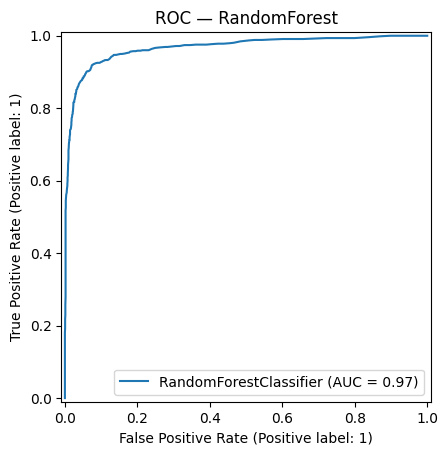

In [26]:
# ROC curve
plt.figure()
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f"ROC — {best_model_name}")
plt.savefig(f"artifacts/figures/roc_{best_model_name}.png", dpi=150, bbox_inches="tight")
plt.show()


<Figure size 640x480 with 0 Axes>

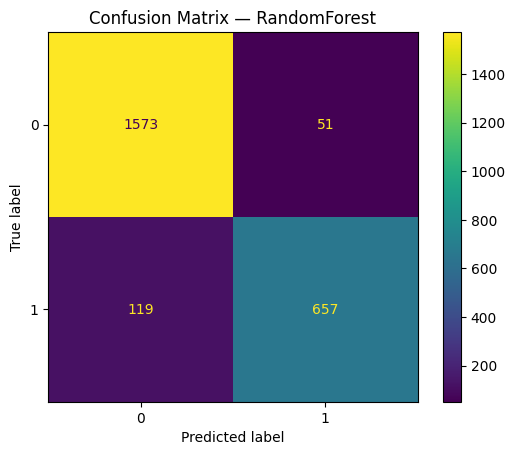

In [27]:
# Confusion matrix
plt.figure()
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix — {best_model_name}")
plt.savefig(f"artifacts/figures/cm_{best_model_name}.png", dpi=150, bbox_inches="tight")
plt.show()


## 8. Интерпретация лучшей модели: permutation importance

Я считаю permutation importance для лучшей модели.
Показываю топ-10 признаков и (по желанию) сохраняю график.


In [28]:
perm = permutation_importance(
    best_model,
    X_test, y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="roc_auc"
)

imp_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

imp_df.head(10)


,feature,importance_mean,importance_std
18,num19,0.062417,0.002084
17,num18,0.053685,0.003739
6,num07,0.024719,0.000995
3,num04,0.015819,0.001158
19,num20,0.013774,0.001996
0,num01,0.010194,0.000879
23,num24,0.007823,0.000701
7,num08,0.006769,0.000672
21,num22,0.006527,0.001154
15,num16,0.005656,0.000714


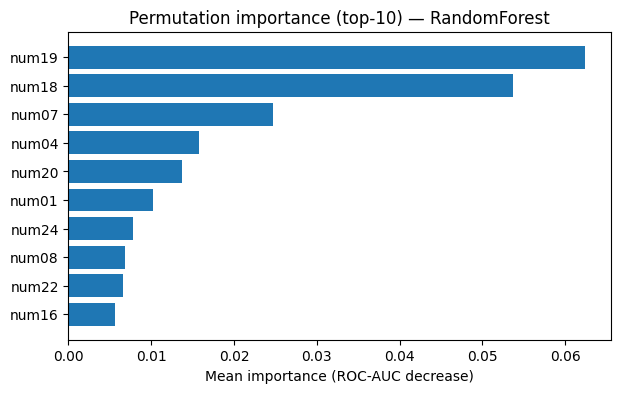

In [29]:
# График top-10 (это будет третья картинка; можно оставить, это не лишнее)
top10 = imp_df.head(10).iloc[::-1]

plt.figure(figsize=(7, 4))
plt.barh(top10["feature"], top10["importance_mean"])
plt.title(f"Permutation importance (top-10) — {best_model_name}")
plt.xlabel("Mean importance (ROC-AUC decrease)")
plt.savefig(f"artifacts/figures/importance_{best_model_name}.png", dpi=150, bbox_inches="tight")
plt.show()


Мои выводы по importance:
- Признаки с наибольшей importance сильнее всего влияют на качество (если их перемешать, ROC-AUC падает).
- Я ожидаю, что среди важных могут быть `tenure_months` и некоторые `cat_*`, потому что деревья/ансамбли хорошо ловят пороги и разбиения.


## 9. Сохранение артефактов в artifacts/

Я сохраняю обязательные файлы:
- artifacts/metrics_test.json
- artifacts/search_summaries.json
- artifacts/best_model.joblib
- artifacts/best_model_meta.json


In [30]:
# 1) metrics_test.json
with open("artifacts/metrics_test.json", "w", encoding="utf-8") as f:
    json.dump(results_test, f, ensure_ascii=False, indent=2)

# 2) search_summaries.json
with open("artifacts/search_summaries.json", "w", encoding="utf-8") as f:
    json.dump(search_summaries, f, ensure_ascii=False, indent=2)

# 3) best_model.joblib
joblib.dump(best_model, "artifacts/best_model.joblib")

# 4) best_model_meta.json
best_model_meta = {
    "best_model_name": best_model_name,
    "best_model_test_metrics": results_test[best_model_name],
    "best_model_params": best_model.get_params()
}

with open("artifacts/best_model_meta.json", "w", encoding="utf-8") as f:
    json.dump(best_model_meta, f, ensure_ascii=False, indent=2)

print("Artifacts saved.")


Artifacts saved.
